# Plotting forming limit curves from forming test data

This analysis starts with data exported from the GOM-correlate software.

Each experiment has 3 sections and each section has data for the major and minor strain. Each experiment is repeated multiple times with multiple sample geometries.

We plot 3 forming limit curves (FLC) from the data using different stopping criteria:
* Formation of a crack in the sample
* First derivative necking 
* Second derivative necking.

Formation of a crack in the material is determined by inspection of the sample images.

First derivative necking determines the necking time to be when the strain in the sample becomes localised. This is determined numerically as the point at which the major strain outside the necking region begins to plateau. 

Second derivative necking considers the second derivative of the major strain to determine the necking time. The point at which the second derivative devaites from a constant value is consdiered the necking point.

In [1]:
from pathlib import Path
import math
import pprint
import glob
from typing import List, Union
from datetime import datetime

from scipy.signal import find_peaks
import lmfit
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import fixed, interact, Dropdown, IntSlider

The fracture time of each sample is determined by visual inspection of the sample images at each time step. The fracture times are listed here, one for each sample.

In [2]:
fracture_times = \
{'Surfalex_10mm_001': 145,
 'Surfalex_10mm_002': 137,
 'Surfalex_10mm_003': 143,
 'Surfalex_20mm_001': 139,
 'Surfalex_20mm_002': 134,
 'Surfalex_20mm_003': 140,
 'Surfalex_40mm_001': 151,
 'Surfalex_40mm_002': 151,
 'Surfalex_40mm_003': 149,
 'Surfalex_60mm_001': 155,
 'Surfalex_60mm_002': 153,
 'Surfalex_60mm_003': 155,
 'Surfalex_120mm_001': 150,
 'Surfalex_120mm_002': 149,
 'Surfalex_120mm_003': 148,
 'Surfalex_full circle_001': 152,
 'Surfalex_fullcircle_002': 157,
 'Surfalex_fullcircle_003': 151
}

First we load the DIC data from the files up the the time of fracture for each sample.

In [3]:
def get_time_from_file(path: Path) -> datetime:
    sample_time_string = pd.read_csv(path, skiprows=2, delimiter=";", nrows=1)["date"].values[0]
    return datetime.fromisoformat(sample_time_string)


def load_data(file_directory: str, fracture_time: int) -> Union[List[np.ndarray], float]:
    frames = []
    sample_times = []
    file_list = sorted(glob.glob(f"{file_directory}/*.csv"))

    # We ignore the first frame since it is before the experiment begins and we ignore frames after fracture
    start_time = get_time_from_file(Path(file_list[1]))

    for index, file_name in enumerate(file_list):
        # Add one to index becuase python is zero based but file numbering is one based.
        if 1 < index + 1 < fracture_time:
            file_path = Path(file_name)
            sample_times.append((get_time_from_file(file_path) - start_time).total_seconds())
            data = np.genfromtxt(file_path, skip_header=6, delimiter=";", usecols=[5])
            frames.append(data)
    return frames, sample_times

major_strain_data = {}
minor_strain_data = {}
frame_times = {}
for experiment_name, fracture_time in tqdm(fracture_times.items()):
    file_directory = f"../Data/strain/{experiment_name}/Section one/major strain"
    major_strain_data[experiment_name], time = load_data(file_directory, fracture_time)    
    frame_times[experiment_name] = time
    
    file_directory = f"../Data/strain/{experiment_name}/Section one/minor strain"
    minor_strain_data[experiment_name], _ = load_data(file_directory, fracture_time)

## 1). FLC from crack formation

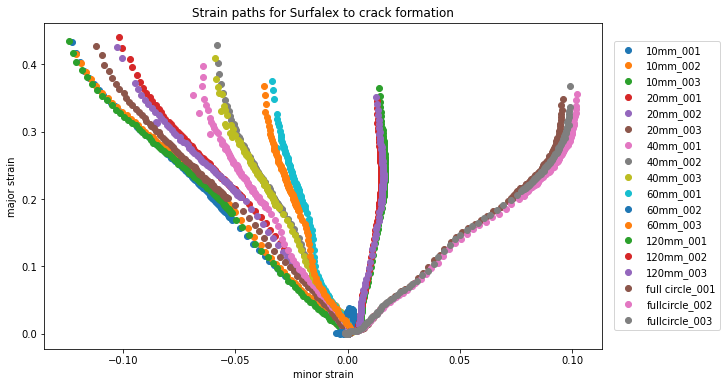

In [4]:
plt.figure(figsize=(10,6))
minor_frac = []
major_frac = []

for experiment_name, fracture_time in fracture_times.items():
    # Find the position of the maximum strain as it breaks. 
    max_strain_index = np.argmax(major_strain_data[experiment_name][-1])

    # Collect major strain over time at the fracture position
    major_strain = [timestep[max_strain_index] for timestep in major_strain_data[experiment_name]]

    # Collect the same data but for minor strains
    minor_strain = [timestep[max_strain_index] for timestep in minor_strain_data[experiment_name]]

    major_frac.append(major_strain[-1])
    minor_frac.append(minor_strain[-1])
    
    plt.plot(minor_strain[:fracture_time - 1], major_strain[:fracture_time - 1], "o", label=experiment_name[9:])
plt.xlabel("minor strain")
plt.ylabel("major strain")
plt.title(f"Strain paths for Surfalex to crack formation")
plt.legend(loc= 'center right', bbox_to_anchor=(1.22, 0.5))
#plt.savefig("../Results/strain_path_to_break.png", dpi=200)

## 2). FLC from first derivative necking

First derivative necking determines the necking time to be when the strain in the sample becomes localised. This is determined numerically as the point at which the major strain outside the necking region begins to plateau.

In order to measure this we need to collect the evolution of the strain with time at the necking point and away from the necking point. In these samples the strain localisation is bimodal. We identify the necking point as the point of maximum strain at the timestep before the sample fails, this is typically at one end of the sample. We identify the point away from the neck to be the point of minimum strain between the two peaks at fracture.

In the below cells we build the analysis step by step.

The first cell shows strain profile at at fracture time. The maximum strain point is marked with a grey line and the minimum strain point is marked by a red line.

In [5]:
plt.figure(figsize=(10,6))
def get_max_strain_index(major_strain_data: np.ndarray, experiment_name: str) -> int:
    """Finds the maximum strain for a strain profile of `experiment_name` at fracture time."""
    peaks, peak_properties = find_peaks(major_strain_data[experiment_name][-1], distance=50, height=0)
    return peaks[np.argmax(peak_properties["peak_heights"])]

def get_min_strain_index(major_strain_data: np.ndarray, experiment_name: str) -> int:
    """Finds the minimum strain between two maxima for a strain profile of `experiment_name` at fracture time."""
    peaks, peak_properties = find_peaks(major_strain_data[experiment_name][-1], distance=50, height=0)
    return np.argmin(major_strain_data[experiment_name][-1][peaks[0]:peaks[1]]) + peaks[0]

def plot_strain_max_min(major_strain_data: np.ndarray, experiment_name: str): 
    """Plot the identified minimum and maximum strain on the strain profile."""
    max_strain_index = get_max_strain_index(major_strain_data, experiment_name)
    min_strain_index = get_min_strain_index(major_strain_data, experiment_name)
    
    plt.plot(major_strain_data[experiment_name][-1])
    plt.vlines(max_strain_index, plt.ylim()[0], plt.ylim()[1], alpha=0.5, color="k")
    plt.vlines(min_strain_index, plt.ylim()[0], plt.ylim()[1], color="r", alpha=0.5)
    plt.title(f"Strain map of sample: {experiment_name} at fracture time")
    plt.xlabel("Vertical sample position")
    plt.ylabel("Strain")
    plt.show()

interact(plot_strain_max_min,
         major_strain_data=fixed(major_strain_data),
         experiment_name=list(fracture_times.keys())
         );

<Figure size 720x432 with 0 Axes>

interactive(children=(Dropdown(description='experiment_name', options=('Surfalex_10mm_001', 'Surfalex_10mm_002…

We now collect the major and minor strain over time at the neck and away from the neck. 

We cut off the data from before 20 seconds since there are some early fluctuations which do not represent necking but make the later fitting harder. We know that the necking does not occur before 20 seconds in any of the samples.

In [6]:
plt.figure(figsize=(10,6))
time_cutoff = 20

def get_index(value: float, data: Union[list, np.ndarray]) -> int:   
    """Return the index of the data point, closest to `value` in `data`."""
    return np.argmin(np.abs(np.array(data) - value))

def get_strain(experiment_name: str, frame_times: np.ndarray, major_strain_data: np.ndarray, crop_index: int):
    """Get strain at the neck and away from the neck. Crop values at inital value `crop_index`."""
    # Get indices of max and min strain
    max_strain_index = get_max_strain_index(major_strain_data, experiment_name)
    min_strain_index = get_min_strain_index(major_strain_data, experiment_name)

    # Collect strain over time at and away from neck
    major_strain_at_neck = [timestep[max_strain_index] for timestep in major_strain_data[experiment_name]]
    major_strain_away_neck = [timestep[min_strain_index] for timestep in major_strain_data[experiment_name]]
    
    return major_strain_at_neck[crop_index:], major_strain_away_neck[crop_index:]

def get_frame_times(experiment_name: str, crop_index: int) -> np.ndarray:
    """Get the time data for `experiment_name` starting at index `crop_index`"""
    return frame_times[experiment_name][crop_index:]

def plot_strain_over_time(experiment_name: str, frame_times: np.ndarray, major_strain_data: np.ndarray):
    # Get the index of the data point at `time_cutoff` seconds for cropping
    crop_index = get_index(frame_times[experiment_name], time_cutoff)
    
    time = get_frame_times(experiment_name, crop_index)
    major_strain_at_neck, major_strain_away_neck = get_strain(experiment_name, frame_times, major_strain_data, crop_index)
    
    plt.plot(time, major_strain_at_neck, "x", label="At neck")
    plt.plot(time, major_strain_away_neck, "x", label="Away from neck")
    plt.xlabel("Time (s)")
    plt.title(f"Major strain for experiment: {experiment_name} at two points")
    plt.ylabel("Strain")
    plt.legend()
    plt.show()

interact(plot_strain_over_time,
         experiment_name=list(fracture_times.keys()),
         frame_times=fixed(frame_times),
         major_strain_data=fixed(major_strain_data)
        );

<Figure size 720x432 with 0 Axes>

interactive(children=(Dropdown(description='experiment_name', options=('Surfalex_10mm_001', 'Surfalex_10mm_002…

Although the data looks good, it is a little noisy which becomes problematic when calculating the strain rate. For this reason we fit the strain with a polynomial in order to smooth it. The below plot allows changing of the order of the polynmial fit to see how this affects the fit.

In [7]:
def polynomial_fit(order: int, x_data: np.ndarray, y_data: np.ndarray, plot_fit: bool = False) -> np.ndarray:
    """Do a polynomial fit of order `order` to the provided x and y data, returning the fit result."""
    strain_model = lmfit.models.PolynomialModel(order)
    params = strain_model.make_params(c0=0, c1=0, c2=0, c3=0, c4=0, c5=0, c6=0, c7=0)
    strain_fit = strain_model.fit(y_data, params, x=x_data)
    if plot_fit:
        strain_fit.plot(numpoints=500)

    smoothed_data = strain_fit.eval(x=x_data)
    return smoothed_data

def fit_strain(experiment_name: str, at_order: int, away_order: int):
    crop_index = get_index(frame_times[experiment_name], time_cutoff)
    
    time = get_frame_times(experiment_name, crop_index)
    major_strain_at_neck, major_strain_away_neck = get_strain(experiment_name, frame_times, major_strain_data, crop_index)

    smooth_strain_at_neck = polynomial_fit(at_order, time, major_strain_at_neck, plot_fit=True)
    smooth_strain_away_neck = polynomial_fit(away_order, time, major_strain_away_neck, plot_fit=True)


interact(fit_strain,
         experiment_name=list(fracture_times.keys()),
         at_order=IntSlider(min=1, value=7, max=7, description="Order of polynomial fit for at neck stress"),
         away_order=IntSlider(min=1, value=3, max=7, description="Order of polynomial fit for away from neck stress")
        );

interactive(children=(Dropdown(description='experiment_name', options=('Surfalex_10mm_001', 'Surfalex_10mm_002…

Now we calulate the first derivative of the strains and the ratio, note that we use an order 7 polynomial fit for the strain at the neck but away from the neck we use an order 3 fit as this is sufficient for a good fit across all data sets.

The slider in the interactive graph allows you to find the time at which the sample reaches a certain strain ratio.

In [8]:
plt.figure(figsize=(10,6))
def get_strain_ratio(experiment_name: str, frame_times: np.ndarray, major_strain_data: np.ndarray, crop_index: int):
    time = get_frame_times(experiment_name, crop_index)
    major_strain_at_neck, major_strain_away_neck = get_strain(experiment_name, frame_times, major_strain_data, crop_index)

    smooth_strain_at_neck = polynomial_fit(7, time, major_strain_at_neck)
    smooth_strain_away_neck = polynomial_fit(3, time, major_strain_away_neck)
    
    strain_rate_at_neck = np.gradient(smooth_strain_at_neck, time)
    strain_rate_away_neck = np.gradient(smooth_strain_away_neck, time)
    return strain_rate_at_neck / strain_rate_away_neck

def plot_strain_ratio(experiment_name: str, frame_times: np.ndarray, major_strain_data: np.ndarray, cutoff_ratio: int):
    """Plot the ratio of the strain rate at the fracture point to the strain rate away from it."""
    crop_index = get_index(frame_times[experiment_name], time_cutoff)
    
    # X and Y data
    time = get_frame_times(experiment_name, crop_index)
    ratio = get_strain_ratio(experiment_name, frame_times, major_strain_data, crop_index)
    
    # Find the point at which we want to cut the FLC
    neck_index = get_index(ratio, cutoff_ratio)
    neck_time = time[neck_index] 

    plt.plot(time, ratio, "x")
    plt.vlines(neck_time, plt.ylim()[0], plt.ylim()[1])
    plt.hlines(cutoff_ratio, plt.xlim()[0], plt.xlim()[1])
    plt.title(f"Ratio of strain rate at neck to strain away\n from neck for experiment {experiment_name}")
    plt.xlabel("Time (s)")
    plt.ylabel("Ratio")
    plt.ylim(0, 20)
    plt.show()

interact(plot_strain_ratio,
         experiment_name=list(fracture_times.keys()),
         frame_times=fixed(frame_times),
         major_strain_data=fixed(major_strain_data),
         cutoff_ratio=IntSlider(min=1, value=10, max=20, continuous_update=True)
        );

<Figure size 720x432 with 0 Axes>

interactive(children=(Dropdown(description='experiment_name', options=('Surfalex_10mm_001', 'Surfalex_10mm_002…

We choose a ratio of 10 as the point at which the sample necks. We then use this as the cut off value for determining the forming limit curve.

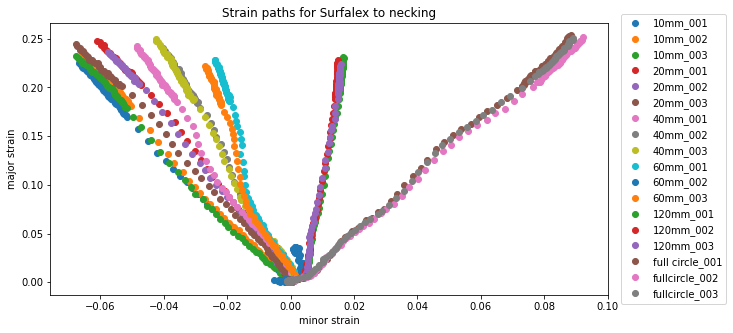

In [9]:
cutoff_ratio = 10
plt.figure(figsize=(10,5))

major_last=[]
minor_last=[]

for experiment_name, fracture_time in fracture_times.items():
    crop_index = get_index(frame_times[experiment_name], time_cutoff)
    
    time = get_frame_times(experiment_name, crop_index)
    ratio = get_strain_ratio(experiment_name, frame_times, major_strain_data, crop_index)
    
    # The neck time is for the cropped data so have to add crop index back on to index the raw data
    neck_index = get_index(ratio, cutoff_ratio) + crop_index
    
    # Find the position of the maximum strain as sample breaks. 
    max_strain_index = np.argmax(major_strain_data[experiment_name][-1])
    
    # Collect strains over time at the break position
    major_strain = [timestep[max_strain_index] for timestep in major_strain_data[experiment_name]]
    minor_strain = [timestep[max_strain_index] for timestep in minor_strain_data[experiment_name]]
    major_last.append(major_strain[neck_index])
    minor_last.append(minor_strain[neck_index])

    plt.plot(minor_strain[:neck_index], major_strain[:neck_index], "o", label=experiment_name[9:])
    
plt.xlabel("minor strain")
plt.ylabel("major strain")
plt.title(f"Strain paths for Surfalex to necking")
plt.legend(loc='center right', bbox_to_anchor=(1.22, 0.5))
plt.savefig("../Results/strain_path_to_neck.png", dpi=200)

# Plot FLD

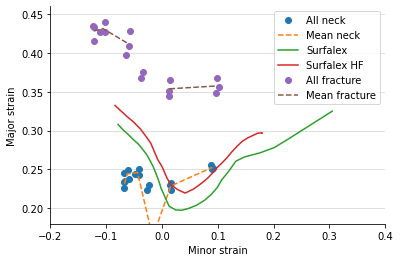

In [10]:
def plot_fld(minor_strain, major_strain):
    mean_minor=[]
    mean_major=[]
    for n in range(0,16,3):
        mean_minor.append(np.mean(minor_strain[n:n+3])) 
        mean_major.append(np.mean(major_strain[n:n+3]))
    plt.plot(minor_strain, major_strain,'o')
    plt.plot(mean_minor, mean_major,'--')
    plt.ylim(0.180,0.46)
    plt.xlim(-0.2,0.4)
    plt.ylabel('Major strain')
    plt.xlabel('Minor strain')
    ax=plt.gca()
    #ax.spines['left'].set_position('zero')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', alpha=0.5)
    
def plot_constellium():
    data=np.loadtxt('../Data/constellium/constellium_data.txt')
    plt.plot(data[:,0],data[:,1])
    plt.plot(data[:,2],data[:,3])
    
plt.figure()
plot_fld(minor_last, major_last)
plot_constellium()
plot_fld(minor_frac, major_frac)
plt.legend(['All neck', 'Mean neck', 'Surfalex', 'Surfalex HF', 'All fracture', 'Mean fracture'])